In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout, Activation, RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
import keras_tuner as kt
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from random import shuffle

In [2]:
DIR_TRAIN_DATA = 'train'
DIR_TEST_DATA = 'test1'
SIZE = 128 #size of the reshaped images (looks clearn & not too large)
CAT = 0
DOG = 1

In [3]:
def preprocess(filename):
    list_of_pictures = os.listdir(filename)
    X = [] # List for images
    y = [] # List for labels
    for picture in list_of_pictures:
        pic_path = os.path.join(filename, picture)
        img = cv2.imread(pic_path)
        img_resized = cv2.resize(img, (SIZE, SIZE))
        if 'cat' in picture: # Ignore images with no fitting label
            y.append(CAT)
            X.append(img_resized)
        elif 'dog' in picture:
            y.append(DOG)
            X.append(img_resized)
    #either split the data now or use validation_split while fitting the model
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=5_000, shuffle=True, random_state=42)
    X_train_array = np.array(X_train).astype('float32') / 255.0
    y_train_array = np.array(y_train).astype('float32')
    X_valid_array = np.array(X_valid).astype('float32') / 255.0
    y_valid_array = np.array(y_valid).astype('float32')
    
    return X_train_array, X_valid_array, y_train_array, y_valid_array

In [4]:
X_train, X_valid, y_train, y_valid = preprocess(filename=DIR_TRAIN_DATA)

In [5]:
#testset has no labels, needs different preprocessing-function
def preprocess_test(filename):
    list_of_pictures = os.listdir(filename)
    X = []
    for picture in list_of_pictures:
        pic_path = os.path.join(filename, picture)
        img = cv2.imread(pic_path)
        img_resized = cv2.resize(img, (SIZE, SIZE))
        X.append(img_resized)
    shuffle(X)
    X_array = np.array(X).astype('float32') / 255.0
    return X_array

In [6]:
X_test = preprocess_test(filename=DIR_TEST_DATA)

In [13]:
#Build the model & tune hyperparameters
def build_model(hp):
    model = keras.models.Sequential()
    
    model.add(Conv2D(
        filters=hp.Int('1_Conv_Filter', 32, 512, 32),
        kernel_size=3,
        input_shape=(SIZE, SIZE, 3)))
    model.add(MaxPool2D())
    
    if hp.Boolean('2_Conv2D'):
        model.add(Conv2D(
            filters=hp.Int('2_Conv_Filter', 32, 512, 32),
            kernel_size=3))
        if hp.Boolean('2_MaxPool'):
            model.add(MaxPool2D())
    
    if hp.Boolean('3_Conv2D'):
        model.add(Conv2D(
            filters=hp.Int('3_Conv_Filter', 32, 512, 32),
            kernel_size=3))
    
    model.add(Flatten())
    
    if hp.Boolean('1_BatchNorm'):
        model.add(BatchNormalization())
    
    model.add(Dense(units=hp.Int('1_Dense_Units', 32, 256, 32)))
    
    if hp.Boolean('2_BatchNorm'):
        model.add(BatchNormalization())
    
    model.add(Activation(relu))
    
    if hp.Boolean('1_Dropout'):
        model.add(Dropout(rate=hp.Float('1_Dropout_Rate', 0.1, 0.5, 0.1)))
    
    model.add(Dense(units=hp.Int('2_Dense_Units', 32, 256, 32)))
    
    if hp.Boolean('3_BatchNorm'):
        model.add(BatchNormalization())
        
    model.add(Activation(relu))
    
    if hp.Boolean('2_Dropout'):
        model.add(Dropout(rate=hp.Float('2_Dropout_Rate', 0.1, 0.5, 0.1)))
    
    if hp.Boolean('3_Dense'):
        model.add(Dense(units=hp.Int('3_Dense_Units', 32, 256, 32)))
        if hp.Boolean('4_BatchNorm'):
            model.add(BatchNormalization())
        model.add(Activation(relu))
        if hp.Boolean('3_Dropout'):
            model.add(Dropout(rate=hp.Float('3_Dropout_Rate', 0.1, 0.5, 0.1)))
    
    model.add(Dense(units=1, activation='sigmoid'))
    
    lr = hp.Float("Learning_Rate", min_value=1e-5, max_value=1e-2, sampling="log")
    
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=["accuracy"])
    
    return model

In [14]:
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=20,
    directory='Logs_RandomSearch',
)

In [15]:
tuner.search(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_valid, y_valid))

Trial 20 Complete [00h 02m 06s]
val_accuracy: 0.7508000135421753

Best val_accuracy So Far: 0.7979999780654907
Total elapsed time: 00h 37m 07s
INFO:tensorflow:Oracle triggered exit


In [16]:
tuner.search_space_summary()

Search space summary
Default search space size: 21
1_Conv_Filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
2_Conv2D (Boolean)
{'default': False, 'conditions': []}
3_Conv2D (Boolean)
{'default': False, 'conditions': []}
1_BatchNorm (Boolean)
{'default': False, 'conditions': []}
1_Dense_Units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
2_BatchNorm (Boolean)
{'default': False, 'conditions': []}
1_Dropout (Boolean)
{'default': False, 'conditions': []}
2_Dense_Units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
3_BatchNorm (Boolean)
{'default': False, 'conditions': []}
2_Dropout (Boolean)
{'default': False, 'conditions': []}
3_Dense (Boolean)
{'default': False, 'conditions': []}
Learning_Rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log

In [17]:
tuner.results_summary()

Results summary
Results in Logs_RandomSearch/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
1_Conv_Filter: 64
2_Conv2D: True
3_Conv2D: True
1_BatchNorm: True
1_Dense_Units: 160
2_BatchNorm: True
1_Dropout: False
2_Dense_Units: 64
3_BatchNorm: False
2_Dropout: False
3_Dense: False
Learning_Rate: 0.0007736587313749148
2_Conv_Filter: 320
2_MaxPool: True
3_Conv_Filter: 64
1_Dropout_Rate: 0.5
2_Dropout_Rate: 0.1
3_Dense_Units: 128
4_BatchNorm: False
3_Dropout: False
3_Dropout_Rate: 0.2
Score: 0.7979999780654907
Trial summary
Hyperparameters:
1_Conv_Filter: 448
2_Conv2D: True
3_Conv2D: False
1_BatchNorm: True
1_Dense_Units: 224
2_BatchNorm: False
1_Dropout: True
2_Dense_Units: 192
3_BatchNorm: True
2_Dropout: False
3_Dense: True
Learning_Rate: 0.00012631428550474618
2_Conv_Filter: 480
2_MaxPool: True
3_Conv_Filter: 256
1_Dropout_Rate: 0.2
2_Dropout_Rate: 0.1
3_Dense_Units: 160
4_BatchNorm: True
3_Dropout: False
3_Dropout

In [18]:
best_hp = tuner.get_best_hyperparameters()[0]

In [19]:
best_model = build_model(best_hp)

In [7]:
tb = TensorBoard()
es = EarlyStopping(patience=5)
mc = ModelCheckpoint(filepath='best_model_dogs_vs_cats.h5',
                     save_best_only=True)
cb = [tb, es, mc]

In [21]:
best_model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_valid, y_valid), callbacks=cb)

Epoch 1/50
625/625 [==============================] - 10s 15ms/step - loss: 0.6162 - accuracy: 0.6572 - val_loss: 0.6050 - val_accuracy: 0.6730
Epoch 2/50
625/625 [==============================] - 9s 14ms/step - loss: 0.5293 - accuracy: 0.7344 - val_loss: 0.6689 - val_accuracy: 0.6758
Epoch 3/50
625/625 [==============================] - 9s 15ms/step - loss: 0.4635 - accuracy: 0.7774 - val_loss: 0.5878 - val_accuracy: 0.7212
Epoch 4/50
625/625 [==============================] - 9s 14ms/step - loss: 0.3976 - accuracy: 0.8205 - val_loss: 0.8049 - val_accuracy: 0.6530
Epoch 5/50
625/625 [==============================] - 9s 15ms/step - loss: 0.3290 - accuracy: 0.8560 - val_loss: 0.5527 - val_accuracy: 0.7472
Epoch 6/50
625/625 [==============================] - 9s 14ms/step - loss: 0.2473 - accuracy: 0.9000 - val_loss: 0.5729 - val_accuracy: 0.7752
Epoch 7/50
625/625 [==============================] - 9s 14ms/step - loss: 0.1680 - accuracy: 0.9356 - val_loss: 0.5997 - val_accuracy: 0.774

In [22]:
%load_ext tensorboard
%tensorboard --logdir=./logs --port=6006

In [23]:
#Stärker regularisieren..
tuner.results_summary(1)

Results summary
Results in Logs_RandomSearch/untitled_project
Showing 1 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
1_Conv_Filter: 64
2_Conv2D: True
3_Conv2D: True
1_BatchNorm: True
1_Dense_Units: 160
2_BatchNorm: True
1_Dropout: False
2_Dense_Units: 64
3_BatchNorm: False
2_Dropout: False
3_Dense: False
Learning_Rate: 0.0007736587313749148
2_Conv_Filter: 320
2_MaxPool: True
3_Conv_Filter: 64
1_Dropout_Rate: 0.5
2_Dropout_Rate: 0.1
3_Dense_Units: 128
4_BatchNorm: False
3_Dropout: False
3_Dropout_Rate: 0.2
Score: 0.7979999780654907


In [12]:
def build_model_2(hp):
    
    model = keras.models.Sequential()
    
    if hp.Boolean('Data_Augmentation'):
        model.add(RandomFlip('vertical'))
        model.add(RandomRotation(0.3))
        model.add(RandomZoom(0.2, 0.2))
    
    model.add(Conv2D(filters=64, kernel_size=3, input_shape=(SIZE, SIZE, 3)))
    model.add(MaxPool2D())
    
    model.add(Conv2D(filters=hp.Choice('2_Conv_Filter', [64, 320]), kernel_size=3))
    model.add(MaxPool2D())
    
    model.add(Conv2D(64, kernel_size=3))
    
    model.add(Flatten())
    
    model.add(BatchNormalization())
    
    model.add(Dense(units=160))
    
    model.add(BatchNormalization())
    
    model.add(Activation(relu))
    
    model.add(Dropout(rate=hp.Choice('1_Dropout_Rate', [0.2, 0.35, 0.5])))
    
    model.add(Dense(units=64))
        
    model.add(Activation(relu))
    
    model.add(Dropout(rate=hp.Choice('2_Dropout_Rate', [0.2, 0.35, 0.5])))
    
    model.add(Dense(units=1, activation='sigmoid'))
    
    lr = 7.74e-4
    
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=["accuracy"])
    
    return model

In [13]:
tuner_2 = kt.RandomSearch(
    hypermodel=build_model_2,
    objective='val_accuracy',
    max_trials=10,
    directory='Logs_RandomSearch_2',
)

INFO:tensorflow:Reloading Oracle from existing project Logs_RandomSearch_2/untitled_project/oracle.json


2022-02-17 18:07:16.915268: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


INFO:tensorflow:Reloading Tuner from Logs_RandomSearch_2/untitled_project/tuner0.json


2022-02-17 18:07:16.932722: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 18:07:16.933541: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 18:07:16.935049: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-17 18:07:16.936105: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [34]:
tuner_2.search(X_train, y_train, batch_size=32, epochs=7, validation_data=(X_valid, y_valid),
               callbacks=[EarlyStopping(patience=3)])

Trial 12 Complete [00h 01m 09s]
val_accuracy: 0.7955999970436096

Best val_accuracy So Far: 0.7955999970436096
Total elapsed time: 00h 10m 30s
INFO:tensorflow:Oracle triggered exit


In [14]:
tuner_2.results_summary()

Results summary
Results in Logs_RandomSearch_2/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
Data_Augmentation: False
2_Conv_Filter: 320
1_Dropout_Rate: 0.35
2_Dropout_Rate: 0.5
Score: 0.7955999970436096
Trial summary
Hyperparameters:
Data_Augmentation: False
2_Conv_Filter: 320
1_Dropout_Rate: 0.2
2_Dropout_Rate: 0.35
Score: 0.7871999740600586
Trial summary
Hyperparameters:
Data_Augmentation: False
2_Conv_Filter: 64
1_Dropout_Rate: 0.5
2_Dropout_Rate: 0.5
Score: 0.7825999855995178
Trial summary
Hyperparameters:
Data_Augmentation: True
2_Conv_Filter: 64
1_Dropout_Rate: 0.2
2_Dropout_Rate: 0.35
Score: 0.6948000192642212
Trial summary
Hyperparameters:
Data_Augmentation: True
2_Conv_Filter: 64
1_Dropout_Rate: 0.2
2_Dropout_Rate: 0.5
Score: 0.6754000186920166
Trial summary
Hyperparameters:
Data_Augmentation: True
2_Conv_Filter: 320
1_Dropout_Rate: 0.5
2_Dropout_Rate: 0.35
Score: 0.6740000247955322
Trial summary
Hyperpa

In [15]:
mc_2 = ModelCheckpoint(filepath='best_model_2_dogs_vs_cats.h5', save_best_only=True)
cb_2 = [tb, es, mc_2]

In [16]:
#Modelle 1, 3 & 6 testen
best_hp_2_1 = tuner_2.get_best_hyperparameters(6)[0]
best_hp_2_3 = tuner_2.get_best_hyperparameters(6)[2]
best_hp_2_6 = tuner_2.get_best_hyperparameters(6)[5]

In [17]:
best_model_2_1 = build_model_2(best_hp_2_1)
best_model_2_3 = build_model_2(best_hp_2_3)
best_model_2_6 = build_model_2(best_hp_2_6)

In [18]:
list_of_models = [best_model_2_1, best_model_2_3, best_model_2_6] #models to fit
list_model_names = ['model_2Conv320_NoAug', 'model_2Conv64_NoAug', 'model_2Conc320_WithAug']
for model, model_name in zip(list_of_models, list_model_names):
    mc_2 = ModelCheckpoint(filepath=f'{model_name}.h5', save_best_only=True)
    cb_2 = [mc_2, es, tb]
    model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_valid, y_valid), callbacks=cb_2)

2022-02-17 18:07:25.839998: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3932160000 exceeds 10% of free system memory.
2022-02-17 18:07:27.082649: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3932160000 exceeds 10% of free system memory.


Epoch 1/50


2022-02-17 18:07:28.827041: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-02-17 18:07:29.376222: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-02-17 18:07:29.915279: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


625/625 [==============================] - 12s 15ms/step - loss: 0.6577 - accuracy: 0.6117 - val_loss: 0.8942 - val_accuracy: 0.5158
Epoch 2/50
625/625 [==============================] - 9s 15ms/step - loss: 0.5877 - accuracy: 0.6870 - val_loss: 0.6371 - val_accuracy: 0.6256
Epoch 3/50
625/625 [==============================] - 9s 14ms/step - loss: 0.5386 - accuracy: 0.7300 - val_loss: 0.5538 - val_accuracy: 0.7154
Epoch 4/50
625/625 [==============================] - 9s 14ms/step - loss: 0.4865 - accuracy: 0.7714 - val_loss: 0.4953 - val_accuracy: 0.7652
Epoch 5/50
625/625 [==============================] - 9s 14ms/step - loss: 0.4446 - accuracy: 0.7936 - val_loss: 0.5387 - val_accuracy: 0.7448
Epoch 6/50
625/625 [==============================] - 9s 15ms/step - loss: 0.4146 - accuracy: 0.8122 - val_loss: 0.4543 - val_accuracy: 0.7928
Epoch 7/50
625/625 [==============================] - 9s 14ms/step - loss: 0.3842 - accuracy: 0.8280 - val_loss: 0.4649 - val_accuracy: 0.7810
Epoch 8/5

2022-02-17 18:09:10.229729: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3932160000 exceeds 10% of free system memory.
2022-02-17 18:09:11.439377: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3932160000 exceeds 10% of free system memory.


Epoch 1/50
625/625 [==============================] - 6s 9ms/step - loss: 0.6877 - accuracy: 0.5982 - val_loss: 0.8126 - val_accuracy: 0.5122
Epoch 2/50
625/625 [==============================] - 5s 8ms/step - loss: 0.6022 - accuracy: 0.6700 - val_loss: 0.6056 - val_accuracy: 0.6688
Epoch 3/50
625/625 [==============================] - 5s 8ms/step - loss: 0.5565 - accuracy: 0.7165 - val_loss: 0.6087 - val_accuracy: 0.6852
Epoch 4/50
625/625 [==============================] - 5s 8ms/step - loss: 0.5088 - accuracy: 0.7504 - val_loss: 0.5032 - val_accuracy: 0.7668
Epoch 5/50
625/625 [==============================] - 5s 8ms/step - loss: 0.4684 - accuracy: 0.7837 - val_loss: 0.5161 - val_accuracy: 0.7446
Epoch 6/50
625/625 [==============================] - 5s 8ms/step - loss: 0.4395 - accuracy: 0.7940 - val_loss: 0.4629 - val_accuracy: 0.7834
Epoch 7/50
625/625 [==============================] - 5s 7ms/step - loss: 0.4082 - accuracy: 0.8151 - val_loss: 0.4658 - val_accuracy: 0.7796
Epoch 

2022-02-17 18:10:15.162852: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3932160000 exceeds 10% of free system memory.


Epoch 1/50
625/625 [==============================] - 11s 16ms/step - loss: 0.6969 - accuracy: 0.5651 - val_loss: 0.6803 - val_accuracy: 0.5346
Epoch 2/50
625/625 [==============================] - 9s 15ms/step - loss: 0.6585 - accuracy: 0.6050 - val_loss: 0.7306 - val_accuracy: 0.5544
Epoch 3/50
625/625 [==============================] - 9s 15ms/step - loss: 0.6469 - accuracy: 0.6261 - val_loss: 0.6924 - val_accuracy: 0.5904
Epoch 4/50
625/625 [==============================] - 9s 15ms/step - loss: 0.6342 - accuracy: 0.6447 - val_loss: 0.6757 - val_accuracy: 0.6038
Epoch 5/50
625/625 [==============================] - 9s 15ms/step - loss: 0.6232 - accuracy: 0.6528 - val_loss: 0.7709 - val_accuracy: 0.6178
Epoch 6/50
625/625 [==============================] - 9s 15ms/step - loss: 0.6159 - accuracy: 0.6616 - val_loss: 0.6078 - val_accuracy: 0.6682
Epoch 7/50
625/625 [==============================] - 9s 15ms/step - loss: 0.6073 - accuracy: 0.6736 - val_loss: 0.6192 - val_accuracy: 0.660

In [21]:
final_model = keras.models.load_model(f'{list_model_names[0]}.h5')

In [22]:
y_test_predict = final_model.predict(X_test)
#Predicts wether Image contains a dog or a cat: Cat_Prediction with value <0.5; Dog_Prediction with value >=0.5

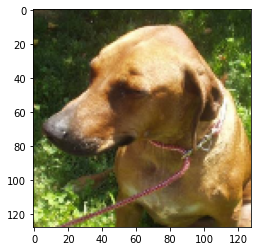

I predict Dog


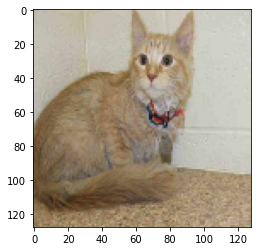

I predict Cat


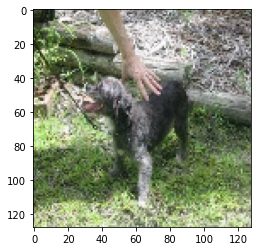

I predict Dog


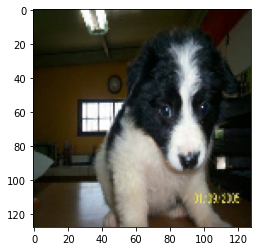

I predict Cat


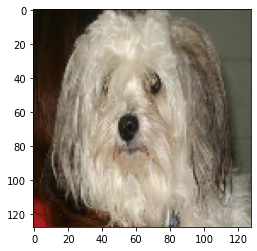

I predict Dog


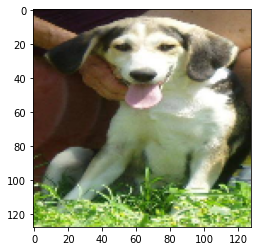

I predict Dog


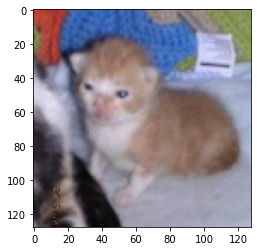

I predict Cat


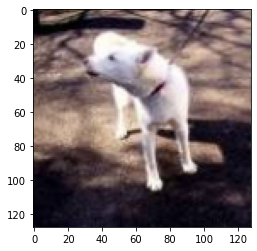

I predict Dog


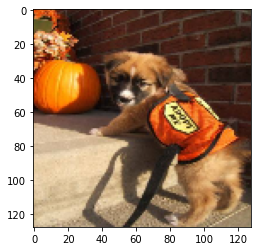

I predict Dog


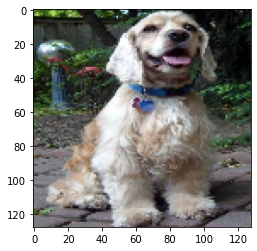

I predict Dog


In [38]:
#Show first 10 Pictures with Predictions:
for num in range(10):
    img_RGB = cv2.cvtColor(X_test[num], cv2.COLOR_BGR2RGB) # matplotlib uses RGB; cv2 uses BGR
    plt.imshow(img_RGB)
    plt.show()
    if round(y_test_predict[num][0], 0) == 0:
        print('I predict Cat')
    elif round(y_test_predict[num][0], 0) == 1:
        print('I predict Dog')

In [39]:
#9/10